In [1]:
import atoti as tt
import pandas as pd

In [2]:
benchmark_df = pd.DataFrame({
    "benchmark_id": ["b1", "b1", "b2", "b3"],
    "cusip": ["pos1", "pos2", "pos2", "pos3"],
    "mv": [10.0, 20.0, 30.0, 40.0]
})
benchmark_df

,benchmark_id,cusip,mv
0,b1,pos1,10.0
1,b1,pos2,20.0
2,b2,pos2,30.0
3,b3,pos3,40.0


In [3]:
portfolio_df = pd.DataFrame({
    "portfolio_id": ["p1", "p2", "p3", "p4"],
    "cusip": ["pos1", "pos2", "pos3", "pos4"],
    "mv": [50.0, 60.0, 70.0, 80.0]
})
portfolio_df

,portfolio_id,cusip,mv
0,p1,pos1,50.0
1,p2,pos2,60.0
2,p3,pos3,70.0
3,p4,pos4,80.0


# Outer Approach

In [4]:
outer_join_session = tt.Session(name="outer")

In [5]:
outer_df = benchmark_df[["benchmark_id", "cusip"]].merge(portfolio_df[["portfolio_id", "cusip"]], how="outer", left_on=["cusip"], right_on=["cusip"])
outer_df

,benchmark_id,cusip,portfolio_id
0,b1,pos1,p1
1,b1,pos2,p2
2,b2,pos2,p2
3,b3,pos3,p3
4,NaN,pos4,p4


In [6]:
outer_table = outer_join_session.read_pandas(
    outer_df, 
    table_name="outer", 
    keys=["portfolio_id", "benchmark_id", "cusip"]
)
outer_table.head()

Empty DataFrame
Columns: []
Index: [(b1, pos1, p1), (b1, pos2, p2), (b2, pos2, p2), (b3, pos3, p3), (N/A, pos4, p4)]

In [7]:
benchmark_table = outer_join_session.read_pandas(benchmark_df, table_name="benchmarks", keys=["cusip", "benchmark_id"])
portfolio_table = outer_join_session.read_pandas(portfolio_df, table_name="portfolio", keys=["cusip", "portfolio_id"])

In [8]:
outer_table.join(benchmark_table)
outer_table.join(portfolio_table)

In [9]:
cube = outer_join_session.create_cube(outer_table)
cube.measures["mv_portfolio.SUM"] = tt.agg.sum(portfolio_table["mv"])
cube.measures["mv_benchmark.SUM"] = tt.agg.sum(benchmark_table["mv"])
cube.measures["Performance %"] = cube.measures["mv_portfolio.SUM"] / cube.measures["mv_benchmark.SUM"]
cube.measures["Performance abs"] = cube.measures["mv_portfolio.SUM"] - cube.measures["mv_benchmark.SUM"]

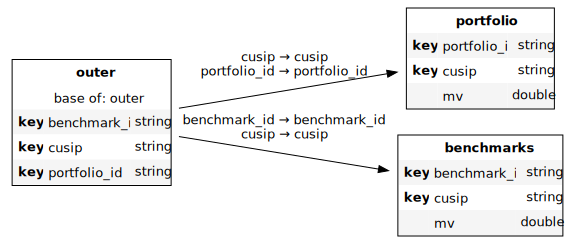

In [10]:
outer_join_session.tables.schema

In [1]:
outer_join_session.widget

NameError: name 'tt' is not defined

# Same Table Approach

In [12]:
same_session = tt.Session(name="same_session")

In [13]:
table = same_session.create_table(
    name="base",
    types={
        "mv": tt.DOUBLE,
        "cusip": tt.STRING,
        "portfolio_id": tt.STRING,
        "benchmark_id": tt.STRING,
    },
    keys=["cusip", "portfolio_id", "benchmark_id"],
    default_values={
        "portfolio_id": "fake_ben",
        "benchmark_id": "fake_por"
    }
)

In [14]:
table.load_pandas(benchmark_df)
table.load_pandas(portfolio_df)

In [15]:
cube = same_session.create_cube(table)
m, l, h = cube.measures, cube.levels, cube.hierarchies

In [16]:
cube.create_parameter_hierarchy_from_members(name="Benchmark_id", members=benchmark_df["benchmark_id"].unique().tolist())

In [17]:
cube.create_parameter_hierarchy_from_members(name="_portfolio_id", members=["fake_ben"])

In [18]:
h["_portfolio_id"].visible=False
h["benchmark_id"].visible=False

In [19]:
h["_portfolio_id"].slicing=True

In [20]:
h["portfolio_id"].slicing=True

In [21]:
m["portfolio_mv"] = tt.filter(m["mv.SUM"], l["benchmark_id"] == "fake_por")

In [40]:
m["benchmark_mv"] = tt.agg.sum(
    tt.at(
        m["mv.SUM"],
        (l["benchmark_id"] == l["Benchmark_id"]) & (l["portfolio_id"] == l["_portfolio_id"]),
    ),
    scope=tt.OriginScope(
        l["benchmark_id"]
    )
)

In [23]:
table.head(16)

mv
cusip portfolio_id benchmark_id      
pos1  fake_ben     b1            10.0
pos2  fake_ben     b1            20.0
                   b2            30.0
pos1  p1           fake_por      50.0
pos3  fake_ben     b3            40.0
pos2  p2           fake_por      60.0
pos3  p3           fake_por      70.0
pos4  p4           fake_por      80.0

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
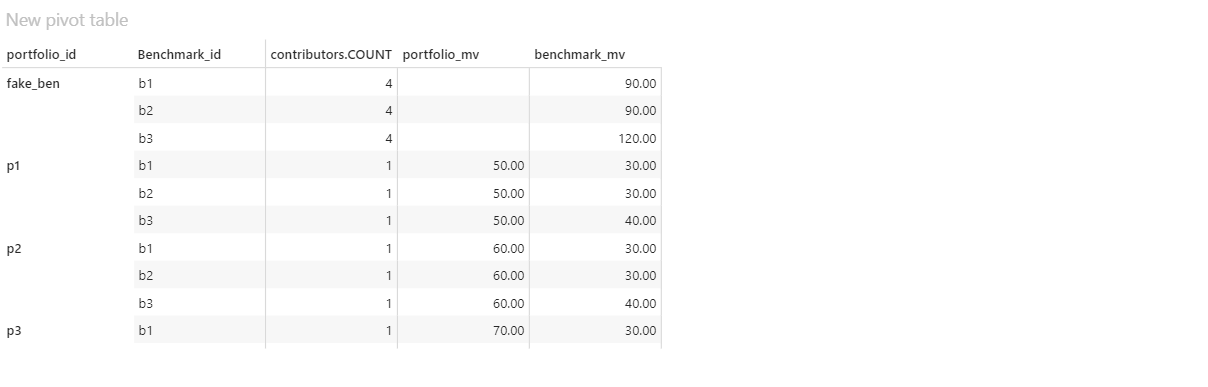

In [41]:
same_session.widget